## In this notebook, you will implement a two-layer neural network model and stochastic gradient descent with momentum in numpy to classify CIFAR-10 images.

In [459]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# preprocess the data
x_train = x_train.reshape(x_train.shape[0], -1).astype('float')
x_test = x_test.reshape(x_test.shape[0], -1).astype('float')
y_train = y_train.squeeze()
y_test = y_test.squeeze()

x_train = x_train - x_train.mean(axis=1, keepdims=True)
x_train = x_train / x_train.std(axis=1, keepdims=True)
x_test = x_test - x_test.mean(axis=1, keepdims=True)
x_test = x_test / x_test.std(axis=1, keepdims=True)

# Implement the forward and backward function for a two-layer neural network

In [460]:
class FullyConnectedNet():
  def __init__(self, hidden_dim, input_dim=3072, num_classes=10):
    super(FullyConnectedNet, self).__init__()
    self.params = {}
    self.params['W1'] = np.random.randn(input_dim, hidden_dim)/np.sqrt(input_dim/2)
    self.params['b1'] = np.zeros(hidden_dim)
    self.params['W2'] = np.random.randn(hidden_dim, num_classes)/np.sqrt(hidden_dim/2)
    self.params['b2'] = np.zeros(num_classes)
    self.grads = {}
    self.grads['W1'] = np.zeros_like(self.params['W1'])
    self.grads['b1'] = np.zeros_like(self.params['b1'])
    self.grads['W2'] = np.zeros_like(self.params['W2'])
    self.grads['b2'] = np.zeros_like(self.params['b2'])
        
  def forward(self, x):
    """Forward pass: linear -- ReLU -- linear
    
    Arguments:
        x: 2D numpy array of shape (batch_size, input_dim)
        
    Returns:
        scores: 2D numpy array of shape (batch_size, num_classes)
        cache: a tuple of numpy arrays, used for backward pass
    """
############################Write your code in this block (20 points)#####################
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = x.shape 
    
    # Compute the forward pass
    scores = None
  
    Z1 = x.dot(W1) + b1
    A1 = np.maximum(0, Z1)

    Z2 = A1.dot(W2) + b2
    A2 = Z2

    scores = A2
        
    # Compute the loss
    cache = None
    scores -= np.max(scores, axis=1,keepdims=True)
      
    scores_e = np.exp(scores)

    cache = np.sum(-1  + np.log(np.sum(scores_e))) / N
    cache += 0.5 * (np.sum(W1 * W1) + np.sum(W2 * W2))   
    
    #################################End of your code#########################################
    return scores, cache
    
  def backward(self, dscores, cache):
    """Backward pass
    
    Arguments:
        dscores: 2D numpy array of shape (batch_size, num_classes)
        cache: a tuple of numpy arrays saved from forward pass
        
    Returns:
        no explicit variable returned
        update self.grads['W1'], self.grads['b1'], self.grads['W2'], self.grads['b2']
    """
    #############################Write your code in this block (30 points)######################
    grads={}
    cache = cache + 0.5 * np.sum(self.params['W1'] * self.params['W1']) + 0.5 * np.sum(self.params['W2'] * self.params['W2'])

    self.grads['W2'] += self.params['W2']
    self.grads['b2'] += self.params['b2']

    self.grads['W1'] +=self.params['W1']
    self.grads['b1'] +=self.params['b1']
    ##################################End of your code##########################################
    return cache, self.grads

In [461]:
# The Cross Entropy Loss has been implemented for you
def cross_entropy_loss(scores, y, eps=1e-8):
  """Calculate cross entropy loss and its gradient with respect to scores
  
  Arguments:
      scores: 2D numpy array of shape (batch_size, num_classes), predicted class scores
      y: 1D numpy array of shape (batch_size,), true class labels (from 0 to num_classes-1)
      
  Returns:
      loss: scalar
      dscores: 2D numpy array of shape (batch_size, num_classes), loss's gradient with respect to scores
      
  """
  scores -= scores.max()
  exp = np.exp(scores)
  exp = np.maximum(exp, eps)
  logits = - scores[range(scores.shape[0]), y] + np.log(exp.sum(axis=1))
  loss = logits.mean()
  dscores = np.zeros_like(scores)
  dscores[range(scores.shape[0]), y] = -1
  dscores += exp/exp.sum(axis=1, keepdims=True)
  dscores /= scores.shape[0]
  return loss, dscores

# Implement SGD with momentum
Initialize $m^{(0)}=0$

After $k$ steps, update $m^{(k+1)}$ and $\theta^{(k+1)}$:
$$m^{(k+1)}=\beta \cdot m^{(k)} + \nabla_{\theta} $$
$$\theta^{(k+1)}=\theta^{(k)} - \alpha \cdot m^{(k+1)}$$
If you want to have a deep understanding of SGD with momentum, I recommend [this article](https://distill.pub/2017/momentum).

In [462]:
class SGD():
  def __init__(self, params, alpha, beta=0):
    """
    Arguments:
      params: a dictionary, with keys being variable names, and values numpy arrays
      alpha: learning rate as shown in the formula in above text cell
      beta: the momentum coefficient, as shown in the formula in the above text cell;
        if beta = 0, then it becomes vallina SGD; Can you figure out why?
    """    
    self.params = params
    self.alpha = alpha
    self.beta = beta
    # Initially, set the momentum m = 0 for all parameters
    self.momentum = {n: np.zeros_like(p) for n, p in self.params.items()}

  def step(self, grads):
    """Perform gradient descent
    Arguments:
        grads: a dictionary, with the same keys as self.params, storing the corresponding gradients;
               for example, grads['W1'] is the gradient with respect to self.params['W1']
    Returns:
        No explicit returns
        Update self.params internally
    """
    #Hint: self.params is a dictionary of parameters,
    ###### use a for loop to iterate all the items from self.params,
    ###### use the formula in the above text cell to update each parameter;
    ###### Note self.momentum and grads are all dictionaries with the same keys as self.params
    ##############################Write your code in this block (20 points)######################
  
    ###################################End of your code##########################################
    return 

# Test your implementation using the following code

In [463]:
hidden_dim = 200
model = FullyConnectedNet(hidden_dim=hidden_dim)

In [464]:
y_pred, _ = model.forward(x_train)
acc_train = np.mean(y_pred.argmax(axis=1) == y_train)
y_pred, _ = model.forward(x_test)
acc_test = np.mean(y_pred.argmax(axis=1) == y_test)
print(f'Before training, training accuracy={acc_train}, test accuracy={acc_test}')

Before training, training accuracy=0.1023, test accuracy=0.1042


In [465]:
loss_history = []
acc_train_history = []
acc_val_history = []

In [466]:
num_iters = 2000
batch_size = 500
alpha = 1e-2
beta = 0.9
optimizer = SGD(model.params, alpha=alpha, beta=beta)
print_every = num_iters//20
for i in range(num_iters):
    idx = np.random.choice(x_train.shape[0], batch_size)
    x_batch = x_train[idx]
    y_batch = y_train[idx]
    scores, cache = model.forward(x_batch)
    loss, dscores = cross_entropy_loss(scores, y_batch)
    model.backward(dscores, cache)
    optimizer.step(model.grads)
    loss_history.append(loss.item())
    acc_train = np.mean(scores.argmax(axis=1) == y_batch)
    acc_train_history.append(acc_train.item())
    # test accuracy
    idx = np.random.choice(x_test.shape[0], batch_size)
    x_batch = x_test[idx]
    y_batch = y_test[idx]
    scores, cache = model.forward(x_batch)
    acc_val = np.mean(scores.argmax(axis=1) == y_batch)
    acc_val_history.append(acc_val.item())
    if i == 0 or i == num_iters-1 or (i+1)%print_every == 0:
        print(f'{i+1} loss={loss}, acc_train={acc_train}, acc_val={acc_val}')

1 loss=2.8817679247849153, acc_train=0.086, acc_val=0.124
100 loss=2.9169929002377146, acc_train=0.104, acc_val=0.088
200 loss=2.804645992669566, acc_train=0.106, acc_val=0.104
300 loss=2.8861608080436887, acc_train=0.124, acc_val=0.096
400 loss=2.9337692603187033, acc_train=0.092, acc_val=0.106
500 loss=3.0055357580358257, acc_train=0.108, acc_val=0.09
600 loss=2.8479624381699633, acc_train=0.106, acc_val=0.1
700 loss=2.8935966116852283, acc_train=0.128, acc_val=0.118
800 loss=2.9022210562015602, acc_train=0.1, acc_val=0.096
900 loss=2.9561673665904253, acc_train=0.082, acc_val=0.112
1000 loss=2.955821541889163, acc_train=0.096, acc_val=0.118
1100 loss=2.8831567652702796, acc_train=0.102, acc_val=0.102
1200 loss=2.9210462432748145, acc_train=0.1, acc_val=0.11
1300 loss=2.892460314481977, acc_train=0.09, acc_val=0.092
1400 loss=2.9746193843466022, acc_train=0.062, acc_val=0.112
1500 loss=2.8869766768473215, acc_train=0.096, acc_val=0.1
1600 loss=2.8732334377889956, acc_train=0.104, acc

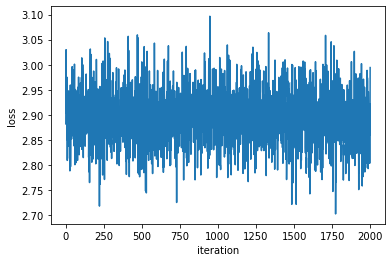

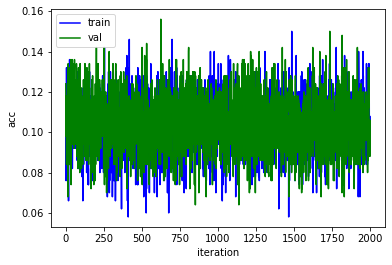

In [467]:
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()
plt.plot(acc_train_history, 'b-', label='train')
plt.plot(acc_val_history, 'g-', label='val')
plt.xlabel('iteration')
plt.ylabel('acc')
plt.legend()
plt.show()

In [468]:
y_pred, _ = model.forward(x_train)
acc_train = np.mean(y_pred.argmax(axis=1) == y_train)
y_pred, _ = model.forward(x_test)
acc_test = np.mean(y_pred.argmax(axis=1) == y_test)
## You should achieve a test accuracy at least 0.4
print(f'After training, training accuracy={acc_train}, test accuracy={acc_test}')

After training, training accuracy=0.1023, test accuracy=0.1042


# Try different hyperparameters: hidden_dim, lr, batch_size, num_iters, find one that can achieve the best test accuracy

1 loss=3.0657220285204083, acc_train=0.075, acc_val=0.15
250 loss=2.9956031091312068, acc_train=0.075, acc_val=0.125
500 loss=3.166230971249594, acc_train=0.05, acc_val=0.1
750 loss=3.058686290003596, acc_train=0.15, acc_val=0.15
1000 loss=2.8284606510698915, acc_train=0.1, acc_val=0.15
1250 loss=2.663105751884636, acc_train=0.1, acc_val=0.1
1500 loss=2.922290494552064, acc_train=0.075, acc_val=0.125
1750 loss=2.81764473199085, acc_train=0.125, acc_val=0.125
2000 loss=2.889204011517789, acc_train=0.05, acc_val=0.025
2250 loss=2.7836689030765114, acc_train=0.075, acc_val=0.075
2500 loss=3.089856037292443, acc_train=0.0, acc_val=0.1
2750 loss=3.1034258218276856, acc_train=0.125, acc_val=0.125
3000 loss=3.332510842886407, acc_train=0.05, acc_val=0.05
3250 loss=3.2008526125021506, acc_train=0.15, acc_val=0.175
3500 loss=2.858377350786681, acc_train=0.15, acc_val=0.1
3750 loss=2.8514762690854263, acc_train=0.175, acc_val=0.075
4000 loss=3.5107177907853186, acc_train=0.025, acc_val=0.1
4250 

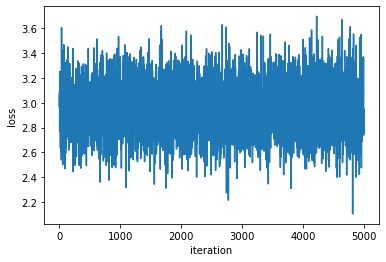

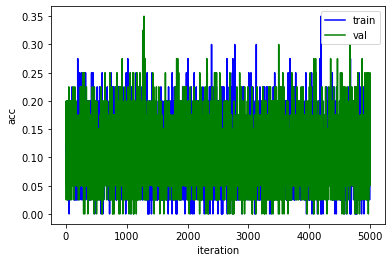

After training, training accuracy=0.10942, test accuracy=0.1069


In [471]:
###############Modify these hyperparameters and find the best ones (20 points)##################
###############You can write a loop to search for the best parameters if your want##############
hidden_dim = 20
alpha = 1e-2
beta = 0
batch_size = 40
num_iters = 5000
#################################################################################################

model = FullyConnectedNet(hidden_dim=hidden_dim)
optimizer = SGD(model.params, alpha=alpha, beta=beta)
loss_history = []
acc_train_history = []
acc_val_history = []
print_every = num_iters//20
for i in range(num_iters):
    idx = np.random.choice(x_train.shape[0], batch_size)
    x_batch = x_train[idx]
    y_batch = y_train[idx]
    scores, cache = model.forward(x_batch)
    loss, dscores = cross_entropy_loss(scores, y_batch)
    model.backward(dscores, cache)
    optimizer.step(model.grads)
    loss_history.append(loss.item())
    acc_train = np.mean(scores.argmax(axis=1) == y_batch)
    acc_train_history.append(acc_train.item())
    # test accuracy
    idx = np.random.choice(x_test.shape[0], batch_size)
    x_batch = x_test[idx]
    y_batch = y_test[idx]
    scores, cache = model.forward(x_batch)
    acc_val = np.mean(scores.argmax(axis=1) == y_batch)
    acc_val_history.append(acc_val.item())
    if i == 0 or i == num_iters-1 or (i+1)%print_every == 0:
        print(f'{i+1} loss={loss}, acc_train={acc_train}, acc_val={acc_val}')
        
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()
plt.plot(acc_train_history, 'b-', label='train')
plt.plot(acc_val_history, 'g-', label='val')
plt.xlabel('iteration')
plt.ylabel('acc')
plt.legend()
plt.show()

y_pred, _ = model.forward(x_train)
acc_train = np.mean(y_pred.argmax(axis=1) == y_train)
y_pred, _ = model.forward(x_test)
acc_test = np.mean(y_pred.argmax(axis=1) == y_test)
## You should achieve a test accuracy at least 0.4
print(f'After training, training accuracy={acc_train}, test accuracy={acc_test}')